In [612]:
# All imports here
import os
import librosa
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import svm
import sklearn
import keras
from keras.utils import np_utils
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import models,regularizers
from tensorflow.keras import layers
%matplotlib inline

# Speaker classification
The way this program works is that it collects the file names, paths and other relevant data for the task and stores it in a dataframe, which is then shuffled and split for training and testing into a 70/30 split. The data is then used to train and test Support Vector Machines with different kernels and a Convolutional Neural Network. The final part of the program consists of the last task, which was using newly recorded samples to test the models yet another time.

#### This first function is used for extracting the files in a directory with the necessary data, and returning them as a dataframe

In [613]:
def create_df(filePath, label):
    fileList = os.listdir(filePath)
    df_obj = pd.DataFrame(fileList)
    # Adding label original to the dataframe to represent original
    df_obj['label'] = label
    df_obj = df_obj.rename(columns={0:'file'})
    df_obj['path'] = filePath
    return df_obj

Storing the labels and paths which we are going to use for the extraction

In [614]:
filePaths = ['recordings/original-recordings', 'recordings/speaker-1-desktop-speakers', 'recordings/speaker-2-soundbox', 'recordings/speaker-3-LG_soundbar', 'recordings/speaker-4-Phillips-tv']

pathsAndLabels = {'original': 'recordings/original-recordings', 'desktop': 'recordings/speaker-1-desktop-speakers',
                 'soundbox': 'recordings/speaker-2-soundbox', 'soundbar': 'recordings/speaker-3-LG_soundbar', 'tv': 'recordings/speaker-4-Phillips-tv'}

Here we create an empty list of dataframes for which the program appends the newly created ones into

In [615]:
dataFrames = [] #Empty list for storing the datatframes

for label, path in pathsAndLabels.items(): # Loop for iterating through the paths and labels and creating the dataframes
    dataFrames.append(create_df(path, label))
    print(label, path)

for i in range(len(dataFrames)):
    print(dataFrames[i])

original recordings/original-recordings
desktop recordings/speaker-1-desktop-speakers
soundbox recordings/speaker-2-soundbox
soundbar recordings/speaker-3-LG_soundbar
tv recordings/speaker-4-Phillips-tv
                    file     label                            path
0    Innspilling (1).m4a  original  recordings/original-recordings
1   Innspilling (10).m4a  original  recordings/original-recordings
2   Innspilling (11).m4a  original  recordings/original-recordings
3   Innspilling (12).m4a  original  recordings/original-recordings
4   Innspilling (13).m4a  original  recordings/original-recordings
5   Innspilling (14).m4a  original  recordings/original-recordings
6   Innspilling (15).m4a  original  recordings/original-recordings
7   Innspilling (16).m4a  original  recordings/original-recordings
8   Innspilling (17).m4a  original  recordings/original-recordings
9   Innspilling (18).m4a  original  recordings/original-recordings
10  Innspilling (19).m4a  original  recordings/original-reco

In [616]:
# Concatenating all the dataframes into a single one
df = pd.concat(dataFrames, ignore_index=True)

print(df[40:100])

                    file     label                                   path
40  Innspilling (46).m4a  original         recordings/original-recordings
41  Innspilling (47).m4a  original         recordings/original-recordings
42  Innspilling (48).m4a  original         recordings/original-recordings
43  Innspilling (49).m4a  original         recordings/original-recordings
44   Innspilling (5).m4a  original         recordings/original-recordings
45  Innspilling (50).m4a  original         recordings/original-recordings
46   Innspilling (6).m4a  original         recordings/original-recordings
47   Innspilling (7).m4a  original         recordings/original-recordings
48   Innspilling (8).m4a  original         recordings/original-recordings
49   Innspilling (9).m4a  original         recordings/original-recordings
50   Innspilling (1).m4a   desktop  recordings/speaker-1-desktop-speakers
51  Innspilling (10).m4a   desktop  recordings/speaker-1-desktop-speakers
52  Innspilling (11).m4a   desktop  re

Splitting the data into 70/30 train and test

In [617]:
# Splitting into test and train data. First randomizing the dataframe containing every sample
df = df.sample(frac=1).reset_index(drop=True)

# Creating a training dataset with 70% of the data
train_df = df.sample(frac=0.7)

# Taking the remaining after the 70 split and putting them into the test datatset
test_df = df.drop(train_df.index)

print(len(test_df))
print(len(train_df))
print(train_df[:60])
print(test_df[:60])


75
175
                     file     label                                   path
235  Innspilling (46).m4a        tv       recordings/speaker-4-Phillips-tv
157  Innspilling (38).m4a  original         recordings/original-recordings
241  Innspilling (48).m4a  soundbox          recordings/speaker-2-soundbox
165  Innspilling (25).m4a  original         recordings/original-recordings
220   Innspilling (9).m4a        tv       recordings/speaker-4-Phillips-tv
209   Innspilling (1).m4a        tv       recordings/speaker-4-Phillips-tv
59   Innspilling (24).m4a   desktop  recordings/speaker-1-desktop-speakers
78   Innspilling (31).m4a  soundbar       recordings/speaker-3-LG_soundbar
42    Innspilling (4).m4a        tv       recordings/speaker-4-Phillips-tv
120  Innspilling (24).m4a        tv       recordings/speaker-4-Phillips-tv
88   Innspilling (12).m4a  soundbox          recordings/speaker-2-soundbox
232  Innspilling (33).m4a        tv       recordings/speaker-4-Phillips-tv
161   Innspilling 

In this segment we verify that the training and test datasets have about the same relative amounts of each label after the shufffling of the dataframe

In [618]:
# Checking that the splits have a reasonably balanced amount of different labels
train_df['label'].value_counts(normalize=True)

tv          0.222857
soundbar    0.211429
desktop     0.200000
original    0.188571
soundbox    0.177143
Name: label, dtype: float64

In [619]:
test_df['label'].value_counts(normalize=True)

soundbox    0.253333
original    0.226667
desktop     0.200000
soundbar    0.173333
tv          0.146667
Name: label, dtype: float64

### The splits have about equal amounts and we decide to leave it at this

#### Below is our function for extracting the MFCCs of each audio file

In [621]:
# Function for extracting the mffcs which we will use as features for the task
# Inspired by and based upon https://www.analyticsvidhya.com/blog/2017/08/audio-voice-processing-deep-learning/

def feature_extract(row):
    # Getting the full path
    fileName = row.path + '/' + row.file
    print('fileName: ', fileName)

    # Loading the file as floating point time series
    X, sample_rate = librosa.load(fileName, res_type='kaiser_fast')

    # Generate MFCCs from the time series
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    feature = mfccs
    label = row.label
    return [feature, label]

tempTrain = train_df.apply(feature_extract, axis=1) # Our new df holding the data with extracted features
print(tempTrain[:10])

tempTest = test_df.apply(feature_extract, axis=1)
print(tempTest[:10])

fileName:  recordings/speaker-4-Phillips-tv/Innspilling (46).m4a
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
fileName:  recordings/original-recordings/Innspilling (38).m4a
fileName:  recordings/speaker-2-soundbox/Innspilling (48).m4a
fileName:  recordings/original-recordings/Innspilling (25).m4a
fileName:  recordings/speaker-4-Phillips-tv/Innspilling (9).m4a
fileName:  recordings/speaker-4-Phillips-tv/Innspilling (1).m4a
fileName:  recordings/speaker-1-desktop-speakers/Innspilling (24).m4a
fileName:  recordings/speaker-3-LG_soundbar/Innspilling (31).m4a
fileName:  recordings/speaker-4-Phillips-tv/Innspilling (4).m4a
fileName:  recordings/speaker-4-Phillips-tv/Innspilling (24).m4a
fileName:  recordings/speaker-2-soundbox/Innspilling (12).m4a
fileName:  recordings/speaker-4-Phillips-tv/Innspilling (33).m4a
fileName:  recordings/speaker-4-Ph

In [622]:
print(tempTrain[1])
print(tempTrain.shape)

[array([-591.32825   ,   58.145115  ,  -30.642847  ,   13.672411  ,
          2.602554  ,   12.371793  ,  -25.468023  ,    7.1586123 ,
        -24.559341  ,    8.191494  ,  -10.488945  ,    4.053541  ,
        -12.448172  ,    1.6702914 ,  -19.699337  ,    2.9578776 ,
         -4.292734  ,   -1.002752  ,   -0.7726733 ,    4.5480847 ,
        -10.21619   ,    2.2369764 ,   -0.82680225,    1.6215646 ,
         -3.311687  ,   -1.3864136 ,    0.9442813 ,   -2.7545183 ,
         -1.5212698 ,   -1.1675965 ,   -1.779974  ,   -2.4015484 ,
         -3.1145072 ,   -4.0840607 ,    0.69110674,   -0.59805316,
         -3.4075685 ,   -1.9741423 ,   -2.8234973 ,   -1.368772  ],
      dtype=float32), 'tv']
(175,)


In [624]:
# Creating our feature matrix and target vector for the training and test set
X_train = []
y_train = []
for obj in tempTrain:
    #print(obj)
    X_train.append(obj[0])
    y_train.append(obj[1])

X_test = []
y_test = []
for obj in tempTest:
    print(obj)
    X_test.append(obj[0])
    y_test.append(obj[1])

[array([-5.8172217e+02,  1.5437065e+01, -2.7147051e+01,  2.6680485e+01,
        8.5790377e+00,  3.0137774e-01, -2.2544842e+01,  1.6496386e+01,
       -2.1896687e+01,  1.1590652e+01, -7.5842280e+00, -1.5515449e+00,
       -1.7282608e+01,  3.3958380e+00, -1.3441625e+01, -5.9454215e-01,
       -5.8711839e+00, -6.2067981e+00, -2.3468170e+00,  3.0843818e+00,
       -7.5957537e+00, -2.0800567e+00, -2.7862184e+00, -7.5124770e-01,
       -3.0628166e+00, -6.7314804e-01,  1.6105751e+00, -1.8564489e+00,
        6.7806154e-01,  1.2673815e+00, -1.9276826e+00, -4.8646188e+00,
        3.1495836e-01, -3.2074275e+00,  1.2309990e+00, -1.6365238e+00,
       -2.0889108e+00, -5.2553755e-01, -3.7409916e+00,  2.6506600e+00],
      dtype=float32), 'desktop']
[array([-5.4316730e+02,  1.3679497e+01, -2.5955370e+01,  2.4771755e+01,
        1.5104321e+00, -2.6881778e+00, -2.6984690e+01,  1.0213340e+01,
       -2.8260460e+01,  1.0069058e+01, -7.6664085e+00,  4.7012833e-01,
       -1.6081234e+01,  4.5798540e+00, -1

In [625]:
# Making separate target arrays for sklearn and keras frameworks, as they work on different target
print(y_train)
print(y_test)

# Creating the target vector for the conventional machine learning algorithms in sklearn which expect integer arrays. Creating an empty list for this
y_train_cl = []
for label in y_train:
    if label == 'original':
        y_train_cl.append(0)
    elif label == 'desktop':
        y_train_cl.append(1)
    elif label == 'soundbox':
        y_train_cl.append(2)
    elif label == 'soundbar':
        y_train_cl.append(3)
    else:
        y_train_cl.append(4)
print(y_train_cl)

# Doing the same thing as above for the test vector
y_test_cl = []
for label in y_test:
    if label == 'original':
        y_test_cl.append(0)
    elif label == 'desktop':
        y_test_cl.append(1)
    elif label == 'soundbox':
        y_test_cl.append(2)
    elif label == 'soundbar':
        y_test_cl.append(3)
    else:
        y_test_cl.append(4)
print(y_test_cl)


['tv', 'original', 'soundbox', 'original', 'tv', 'tv', 'desktop', 'soundbar', 'tv', 'tv', 'soundbox', 'tv', 'tv', 'tv', 'desktop', 'original', 'soundbox', 'original', 'tv', 'tv', 'desktop', 'tv', 'soundbox', 'desktop', 'soundbar', 'soundbox', 'original', 'soundbox', 'soundbox', 'tv', 'soundbar', 'soundbar', 'original', 'soundbar', 'soundbox', 'tv', 'desktop', 'desktop', 'tv', 'tv', 'soundbox', 'desktop', 'soundbox', 'desktop', 'soundbox', 'soundbar', 'original', 'soundbar', 'soundbox', 'original', 'tv', 'desktop', 'desktop', 'tv', 'desktop', 'tv', 'soundbar', 'desktop', 'desktop', 'desktop', 'desktop', 'tv', 'original', 'tv', 'tv', 'desktop', 'soundbar', 'soundbar', 'soundbar', 'soundbar', 'desktop', 'soundbar', 'desktop', 'soundbar', 'tv', 'soundbar', 'desktop', 'soundbar', 'original', 'desktop', 'soundbar', 'original', 'soundbox', 'tv', 'tv', 'original', 'original', 'soundbar', 'desktop', 'soundbar', 'tv', 'original', 'tv', 'original', 'original', 'original', 'soundbox', 'original', 

We ended up not using the hot encoded arrays

In [626]:
# Making separate target arrays for sklearn and keras frameworks, as they work on different target

# Hot encoding y for keras, as keras doesn't use integer target arrays like sklearn
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))

y_test = np_utils.to_categorical(lb.fit_transform(y_test))
print(y_train[0])
print(y_test[0])
print(y_train)

[0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0.]
[[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0

In [627]:
# Converting the training features and test features to a numpy array 
X_train = np.array(X_train)
X_test = np.array(X_test)

print(X_train.shape)
print(X_test.shape)

(175, 40)
(75, 40)


Standardizing the features. This assumes the data has a Gaussian distribution.

In [628]:
# Standardizing the features
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(X_train[:3])
print(y_train[:5])

[[-1.6188706   0.41126454  0.1346086  -1.2211045  -0.559442    0.94084805
  -0.28844193  0.22442767  0.54264987 -0.5157379   0.2832214   0.81851155
   0.7698508  -0.5996754  -0.2559101   0.27164593  0.8598349   1.1497234
   1.4484222   0.31740934  1.0379963   0.33730784  0.72643745  0.2542363
  -0.40380242  0.33642593  0.26946673  0.09685612 -0.48443234 -0.78548515
   0.08640414  0.46069092 -1.6354322  -0.41168883  0.5979216  -0.19200762
  -0.5149683  -0.69042724  0.64910805 -0.8215385 ]
 [ 1.9594336   1.0857      0.34332782  1.8849384   0.25931156 -0.56179446
   0.94528735 -0.7638062   0.6400227   0.34862927 -0.5552682  -0.8227929
   0.94604385 -0.7463177   0.7146383  -0.5162396   0.42767757 -0.7550391
   0.47504565 -0.26055682  1.0966371  -0.35378435  0.20264646 -0.25363174
   0.39448676 -0.277624   -0.13385616 -0.27326104 -0.4839479  -1.0415351
  -0.27482098  0.29593018  0.06537206  0.19433291 -0.89149255 -1.5984582
   1.6437768  -0.8859535  -0.57043475 -1.0304682 ]
 [ 0.2966201   0

# The conventional machine learning algorithm we chose for this task was the Support Vector Machine
The reasoning behind this was first of all that our problem was a classification problem, and SVM can do both classification and regression.
We figured that since the SVM allows us to specify the kernels, and then find an optimal boundary in between these resulting outputs, that it would be the best at separating our data and getting the labels right.

We decided upon testing four different kernel functions for this conventional implementation to see if there was any difference. The theory behind
being that the linear would perform the "best" of them. This being because the number of features in the problem were larger than the number of samples, and that the data was fairly "simple". We also hypothesized that the different models would all easily distinguish between the recordings of the different speakers, seeing as there were clear differences to the naked ear in regards to both volume and perception. With this meaning that the way one would describe sound as a human, the way we percieve it, it was very distinctive and seeing as we used MFCCs, which use Mel scaling to try and model the way a human would hear, our theory was that our models would perform extremely and also maybe unrealistically well.

Our implementation of the SVM with different kernels are below, inspired by the multiclass_svm.py lab material and https://towardsdatascience.com/multiclass-classification-with-support-vector-machines-svm-kernel-trick-kernel-functions-f9d5377d6f02

In [629]:
# Converting the test data integer arrays
y_test_cl = np.array(y_test_cl)
y_train_cl = np.array(y_train_cl)

# The linear SVM
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

# The Radial basis function kernel
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

# The Polynomial kernel
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

# The sigmoid kernel
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train_cl)

### Evaluating the models

In [632]:
# Making the predictions
linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
sig_pred = sig.predict(X_test)

# Measuring the accuracy 
accuracy_lin = linear.score(X_test, y_test_cl)
accuracy_poly = poly.score(X_test, y_test_cl)
accuracy_rbf = rbf.score(X_test, y_test_cl)
accuracy_sig = sig.score(X_test, y_test_cl)

print('Accuracy Linear Kernel:', accuracy_lin)
print('Accuracy Polynomial Kernel:', accuracy_poly)
print('Accuracy Radial Basis Kernel:', accuracy_rbf)
print('Accuracy Sigmoid Kernel:', accuracy_sig)

Accuracy Linear Kernel: 1.0
Accuracy Polynomial Kernel: 1.0
Accuracy Radial Basis Kernel: 0.14666666666666667
Accuracy Sigmoid Kernel: 1.0


### Calculating the F1 scores for all the kernels

In [633]:
# Calculating the F1 score
from sklearn.metrics import f1_score

f1_lin = f1_score(y_test_cl, linear_pred, average='macro')
f1_poly = f1_score(y_test_cl, poly_pred, average='macro')
f1_rbf = f1_score(y_test_cl, rbf_pred, average='macro')
f1_sig = f1_score(y_test_cl, sig_pred, average='macro')

print('linear: ', f1_lin)
print('polynomial: ', f1_poly)
print('radial basis function: ', f1_rbf)
print('sigmoid: ', f1_sig)

linear:  1.0
polynomial:  1.0
radial basis function:  0.05116279069767442
sigmoid:  1.0


### Creating a confusion matrix for all the kernels.

In [437]:
cm_lin = confusion_matrix(y_test_cl, linear_pred)
cm_poly = confusion_matrix(y_test_cl, poly_pred)
cm_rbf = confusion_matrix(y_test_cl, rbf_pred)
cm_sig = confusion_matrix(y_test_cl, sig_pred)
print(cm_lin)
print(cm_poly)
print(cm_rbf)
print(cm_sig)

[[17  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 18  0]
 [ 0  0  0  0 17]]
[[17  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 18  0]
 [ 0  0  0  0 17]]
[[ 0  0 17  0  0]
 [ 0  0 13  0  0]
 [ 0  0 10  0  0]
 [ 0  0 18  0  0]
 [ 0  0 17  0  0]]
[[17  0  0  0  0]
 [ 0 13  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 18  0]
 [ 0  0  0  0 17]]


## What we see here
is that the linear, polynomial and sigmoid kernels all had 100% accuracy, while the radial basis function only managed 0.15%, and also had a bad F1 score. It classified everything as the 'soundbox' label. Our theory regarding the rbf kernel is as previous stated, that the number of features are larger than the number of instances, and this causes the bad performance.

Our main theory for why the other had such high scores is that our dataset is very "clean" and is relatively small also. As previously stated it was easy to classify the different speakers using nothing but our human perception. We think that if we had a larger and messier dataset, we would not have seen 100% accuracy as we are seeing now. 

# Deep learning
For this next section we will use a vanilla CNN model to perform the exact same measures that we did with the support vector machines and
compare the performances. Our theory now points in the direction of the CNN performing worse than the SVM because of the small size of the dataset, but we are not completely sure about this, seeing as the data is also easily classifiable

In [555]:
print(X_test.shape)

(75, 40)


In [556]:
print(X_train.shape)
X_train_rs = X_train.reshape(np.append(X_train.shape, 1))
X_test_rs = X_test.reshape(np.append(X_test.shape, 1))
print(X_train_rs.shape)

print(y_train.shape)
print(y_train_cl.shape)

(175, 40)
(175, 40, 1)
(175, 5)
(175,)


### Creating the CNN model
For this model we chose a rather basic plain design, nothing fancy. We also have to use 1D convolutions because of the dimensions and shape of the audio data, in contrast to 2D convolutions one probably with use when it comes to image classification

In [557]:
# Creating the CNN
model = models.Sequential([
    layers.Conv1D(filters=20, kernel_size=(6), activation='relu', input_shape=(X_train_rs.shape[1:])),
    layers.MaxPooling1D(2),

    layers.Conv1D(filters=44, kernel_size=(6), activation='relu'),
    layers.MaxPooling1D(2),

    layers.Flatten(),
    layers.Dense(127, activation='relu'),
    layers.Dense(5, activation='softmax')
])

### Using the sparse_categorical_crossentropy, seeing as our Y's, target vector, is integer and not one hot encoded, although we were doing one hot encoding at first.

In [558]:
# Compiling the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [559]:
results = model.fit(X_train_rs, y_train_cl, validation_data=(X_test_rs, y_test_cl), epochs=12)

Epoch 1/12
6/6 [==============================] - 1s 47ms/step - loss: 1.5749 - accuracy: 0.2774 - val_loss: 1.2890 - val_accuracy: 0.8267
Epoch 2/12
6/6 [==============================] - 0s 12ms/step - loss: 1.1686 - accuracy: 0.9183 - val_loss: 0.9308 - val_accuracy: 0.8533
Epoch 3/12
6/6 [==============================] - 0s 12ms/step - loss: 0.8204 - accuracy: 0.9159 - val_loss: 0.5650 - val_accuracy: 0.9867
Epoch 4/12
6/6 [==============================] - 0s 13ms/step - loss: 0.4687 - accuracy: 1.0000 - val_loss: 0.3113 - val_accuracy: 0.9733
Epoch 5/12
6/6 [==============================] - 0s 12ms/step - loss: 0.2269 - accuracy: 1.0000 - val_loss: 0.1606 - val_accuracy: 1.0000
Epoch 6/12
6/6 [==============================] - 0s 13ms/step - loss: 0.1106 - accuracy: 0.9949 - val_loss: 0.0886 - val_accuracy: 1.0000
Epoch 7/12
6/6 [==============================] - 0s 12ms/step - loss: 0.0587 - accuracy: 1.0000 - val_loss: 0.0767 - val_accuracy: 0.9867
Epoch 8/12
6/6 [===========

### Visualizing the loss of the model to see if we are over- or underfitting the model.

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Training and validation loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

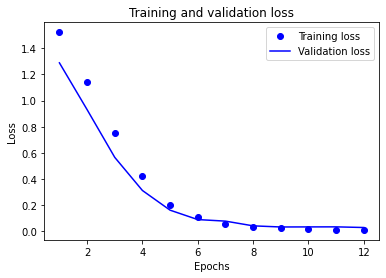

In [561]:
plt.figure()
history_dict = results.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### From the loss graph
we can observe that there seems to be neither overfit nor underfit, the training and validation loss is very similar indicating a good fitting model. Again, our theory for why the results are
so overwhelmigly good is that our dataset is very clean, and differrences are easily observable, and in our case we think this makes it "easy" for the algorithms to predict. 

In [560]:
print("Test-Accuracy:", np.mean(results.history["val_accuracy"]))
losses = results.history['loss']
val_losses = results.history['val_loss']

Test-Accuracy: 0.9655555635690689


In [571]:
y_pred = model.predict(X_test_rs)
y_pred_classes = [np.argmax(elem) for elem in y_pred]

print("Classification report: \n", classification_report(y_test_cl, y_pred_classes)) #Just using the whole classification report to get the F1 score here

print("\n\nConfusion matrix: \n")
cm = confusion_matrix(y_test_cl, y_pred_classes)
print(cm)

Classification report: 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        17
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        10
           3       0.95      1.00      0.97        18
           4       1.00      1.00      1.00        17

    accuracy                           0.99        75
   macro avg       0.99      0.99      0.99        75
weighted avg       0.99      0.99      0.99        75



Confusion matrix: 

[[16  0  0  1  0]
 [ 0 13  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0 18  0]
 [ 0  0  0  0 17]]


### As we see from the f1-score, confusion matrix and classification report
is that this CNN model got one prediction wrong and ended up with 99% accuracy, compared to the SVM (minus the one with rbf-kernel), which had all the predictions right. Again, this is a marginal difference, and the model might have gotten that one class right with a different design. This leads us to conclude with that as of now there is no clear winner between the two models, both models performed exceptionally well, and again this may be down to our "easy-to-predict" and clean datatset. Again, with more samples and more "noise" we might have been able to push the boundary of the models and really see the difference.

# Testing the model again, with newly recorded data
For this next segment we will do the last point of this task, which was to record five new samples in our own voice. We have 25 samples in total to test here. Five for each speaker. We think this part may be interesting, seeing as the new recordings might have had the microphone in different places, or had the recording in a different room than the original recordings, leading to volume and perception differences in the data which were not present before. We think that this may have an impact on the performance

### Using the same approach as last time for loading the files

In [573]:
pathsAndLabels = {'original': 'test_recordings/original-test', 'desktop': 'test_recordings/speaker-1-desktop-test',
                 'soundbox': 'test_recordings/speaker-2-soundbox-test', 'soundbar': 'test_recordings/speaker-3-LG-test', 'tv': 'test_recordings/speaker-4-Phillips-test'}

In [576]:
dataFrames = []

for label, path in pathsAndLabels.items(): # Loop for iterating through the paths and labels and creating the dataframes
    dataFrames.append(create_df(path, label))
    print(label, path)

for i in range(len(dataFrames)):
    print(dataFrames[i])

original test_recordings/original-test
desktop test_recordings/speaker-1-desktop-test
soundbox test_recordings/speaker-2-soundbox-test
soundbar test_recordings/speaker-3-LG-test
tv test_recordings/speaker-4-Phillips-test
                  file     label                           path
0  Innspilling (1).m4a  original  test_recordings/original-test
1  Innspilling (2).m4a  original  test_recordings/original-test
2  Innspilling (3).m4a  original  test_recordings/original-test
3  Innspilling (4).m4a  original  test_recordings/original-test
4  Innspilling (5).m4a  original  test_recordings/original-test
                  file    label                                    path
0  Innspilling (1).m4a  desktop  test_recordings/speaker-1-desktop-test
1  Innspilling (2).m4a  desktop  test_recordings/speaker-1-desktop-test
2  Innspilling (3).m4a  desktop  test_recordings/speaker-1-desktop-test
3  Innspilling (4).m4a  desktop  test_recordings/speaker-1-desktop-test
4  Innspilling (5).m4a  desktop  te

In [578]:
# Concatenating all the dataframes into a single one
df = pd.concat(dataFrames, ignore_index=True)
print(df[:30])

                   file     label                                     path
0   Innspilling (1).m4a  original            test_recordings/original-test
1   Innspilling (2).m4a  original            test_recordings/original-test
2   Innspilling (3).m4a  original            test_recordings/original-test
3   Innspilling (4).m4a  original            test_recordings/original-test
4   Innspilling (5).m4a  original            test_recordings/original-test
5   Innspilling (1).m4a   desktop   test_recordings/speaker-1-desktop-test
6   Innspilling (2).m4a   desktop   test_recordings/speaker-1-desktop-test
7   Innspilling (3).m4a   desktop   test_recordings/speaker-1-desktop-test
8   Innspilling (4).m4a   desktop   test_recordings/speaker-1-desktop-test
9   Innspilling (5).m4a   desktop   test_recordings/speaker-1-desktop-test
10  Innspilling (1).m4a  soundbox  test_recordings/speaker-2-soundbox-test
11  Innspilling (2).m4a  soundbox  test_recordings/speaker-2-soundbox-test
12  Innspilling (3).m4a  

In [580]:
temp = df.apply(feature_extract, axis=1)
print(temp[:30])

fileName:  test_recordings/original-test/Innspilling (1).m4a
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
fileName:  test_recordings/original-test/Innspilling (2).m4a
fileName:  test_recordings/original-test/Innspilling (3).m4a
fileName:  test_recordings/original-test/Innspilling (4).m4a
fileName:  test_recordings/original-test/Innspilling (5).m4a
fileName:  test_recordings/speaker-1-desktop-test/Innspilling (1).m4a
fileName:  test_recordings/speaker-1-desktop-test/Innspilling (2).m4a
fileName:  test_recordings/speaker-1-desktop-test/Innspilling (3).m4a
fileName:  test_recordings/speaker-1-desktop-test/Innspilling (4).m4a
fileName:  test_recordings/speaker-1-desktop-test/Innspilling (5).m4a
fileName:  test_recordings/speaker-2-soundbox-test/Innspilling (1).m4a
fileName:  test_recordings/speaker-2-soundbox-test/Innspilling (2).m4a
fileName:

In [581]:
print(temp.shape)

(25,)


In [584]:
# Creating the feature matrix and target vecor
X_test2 = []
y_test2 = []
for obj in temp:
    print(obj)
    X_test2.append(obj[0])
    if obj[1] == 'original':
        y_test2.append(0)
    elif obj[1] == 'desktop':
        y_test2.append(1)
    elif obj[1] == 'soundbox':
        y_test2.append(2)
    elif obj[1] == 'soundbar':
        y_test2.append(3)
    elif obj[1] == 'tv':
        y_test2.append(4)
    else:
        print("SOMETHING WRONG")

[array([-4.5616788e+02,  7.9606781e+01, -2.2181273e+01,  3.3363731e+01,
        6.3680406e+00,  3.5536611e+00, -1.8797180e+01,  1.6858330e+00,
       -2.0961422e+01,  1.2491478e+01, -1.3951008e+01,  1.0578222e+00,
       -1.3296202e+01, -5.7276659e+00, -1.4251524e+01,  6.8102255e+00,
       -6.0792494e+00, -8.2284966e+00,  2.8709564e-01, -3.0035725e-01,
       -1.4511844e+01, -2.3394647e+00, -4.5736723e+00, -3.5187371e+00,
       -2.4793150e+00, -4.1189704e+00, -4.3277984e+00, -2.3225880e+00,
       -5.9695989e-01, -3.3969650e+00, -2.3564372e+00, -3.7135715e+00,
       -1.9752213e+00, -2.5736887e+00, -5.7381487e-01, -1.3677388e+00,
       -1.7082869e+00, -2.4790225e+00, -2.5228734e+00, -1.2861131e+00],
      dtype=float32), 'original']
[array([-4.8884293e+02,  9.2754021e+01, -2.0403910e+01,  2.0899673e+01,
        1.2169987e+01,  5.6780071e+00, -1.3256531e+01,  4.0701323e+00,
       -1.8758493e+01,  1.0196158e+01, -7.0727992e+00,  1.9707243e-01,
       -1.4840110e+01, -4.9511065e+00, -

In [587]:
print(X_test2[:2])
print(y_test2)

[array([-4.5616788e+02,  7.9606781e+01, -2.2181273e+01,  3.3363731e+01,
        6.3680406e+00,  3.5536611e+00, -1.8797180e+01,  1.6858330e+00,
       -2.0961422e+01,  1.2491478e+01, -1.3951008e+01,  1.0578222e+00,
       -1.3296202e+01, -5.7276659e+00, -1.4251524e+01,  6.8102255e+00,
       -6.0792494e+00, -8.2284966e+00,  2.8709564e-01, -3.0035725e-01,
       -1.4511844e+01, -2.3394647e+00, -4.5736723e+00, -3.5187371e+00,
       -2.4793150e+00, -4.1189704e+00, -4.3277984e+00, -2.3225880e+00,
       -5.9695989e-01, -3.3969650e+00, -2.3564372e+00, -3.7135715e+00,
       -1.9752213e+00, -2.5736887e+00, -5.7381487e-01, -1.3677388e+00,
       -1.7082869e+00, -2.4790225e+00, -2.5228734e+00, -1.2861131e+00],
      dtype=float32), array([-4.8884293e+02,  9.2754021e+01, -2.0403910e+01,  2.0899673e+01,
        1.2169987e+01,  5.6780071e+00, -1.3256531e+01,  4.0701323e+00,
       -1.8758493e+01,  1.0196158e+01, -7.0727992e+00,  1.9707243e-01,
       -1.4840110e+01, -4.9511065e+00, -1.5044881e+01

In [589]:
# Converting both X and y to numpy arrays
X_test2 = np.array(X_test2)
y_test2 = np.array(y_test2)
print(X_test2)
print(y_test2)

[[-4.56167877e+02  7.96067810e+01 -2.21812725e+01  3.33637314e+01
   6.36804056e+00  3.55366111e+00 -1.87971802e+01  1.68583298e+00
  -2.09614220e+01  1.24914780e+01 -1.39510078e+01  1.05782223e+00
  -1.32962017e+01 -5.72766590e+00 -1.42515240e+01  6.81022549e+00
  -6.07924938e+00 -8.22849655e+00  2.87095636e-01 -3.00357252e-01
  -1.45118437e+01 -2.33946466e+00 -4.57367229e+00 -3.51873708e+00
  -2.47931504e+00 -4.11897039e+00 -4.32779837e+00 -2.32258797e+00
  -5.96959889e-01 -3.39696503e+00 -2.35643721e+00 -3.71357155e+00
  -1.97522128e+00 -2.57368875e+00 -5.73814869e-01 -1.36773884e+00
  -1.70828688e+00 -2.47902250e+00 -2.52287340e+00 -1.28611314e+00]
 [-4.88842926e+02  9.27540207e+01 -2.04039097e+01  2.08996735e+01
   1.21699867e+01  5.67800713e+00 -1.32565308e+01  4.07013226e+00
  -1.87584934e+01  1.01961584e+01 -7.07279921e+00  1.97072431e-01
  -1.48401098e+01 -4.95110655e+00 -1.50448809e+01  6.46187514e-02
  -4.32263136e+00 -6.08019876e+00 -3.86544037e+00 -2.38884068e+00
  -7.7977

In [605]:
# Standardizing the features
X_test2 = scaler.fit_transform(X_test2)
print(X_test2)

[[ 1.0950286   1.2871107   0.7331379   1.144905   -0.321826    0.38363898
   0.46420735 -0.93768936  1.6444623   0.48640642  0.30870658  0.13742627
   0.9097219  -0.8807658   1.3435317   0.34611142  0.27732182 -2.2191648
   0.6794654  -0.37628776 -0.20105104 -0.36789525  0.0267664  -0.5495583
  -0.62725127 -1.4508902  -1.2784597   1.0424565  -0.65971035 -1.9560868
   0.1146407  -0.4084372   0.37201136 -0.54848987 -1.9274702  -0.07761235
   0.5065165  -0.43126735  0.04850386 -0.338496  ]
 [ 0.26441035  1.8731834   0.8397034   0.26334193  0.3302036   0.73675346
   1.2791787  -0.33448002  1.9783914   0.15210614  1.5409713  -0.10144756
   0.67084163 -0.7189212   1.1829118  -1.4710959   0.81736875 -1.511827
  -0.34505922 -0.74611306  1.2303517  -0.96979195  0.53216326 -0.27066743
   0.17287184 -0.5777714   0.39069742  1.0366776  -0.24885856 -0.6533042
  -0.45708823 -0.2969109   0.4900352  -0.9425052  -1.3091215  -0.21492328
  -0.6221407  -0.5349104  -0.09599412 -0.02012658]
 [ 0.88484347  1

# Measuring the accuracy of the four different SVM kernels

In [600]:
# Measuring the accuracy 
accuracy_lin = linear.score(X_test2, y_test2)
accuracy_poly = poly.score(X_test2, y_test2)
accuracy_rbf = rbf.score(X_test2, y_test2)
accuracy_sig = sig.score(X_test2, y_test2)

print('Accuracy Linear Kernel:', accuracy_lin)
print('Accuracy Polynomial Kernel:', accuracy_poly)
print('Accuracy Radial Basis Kernel:', accuracy_rbf)
print('Accuracy Sigmoid Kernel:', accuracy_sig)

# Making the predictions
linear_pred = linear.predict(X_test2)
poly_pred = poly.predict(X_test2)
rbf_pred = rbf.predict(X_test2)
sig_pred = sig.predict(X_test2)

print("\nConfusion matrix:")
cm_lin = confusion_matrix(y_test2, linear_pred)
cm_poly = confusion_matrix(y_test2, poly_pred)
cm_rbf = confusion_matrix(y_test2, rbf_pred)
cm_sig = confusion_matrix(y_test2, sig_pred)
print(cm_lin)
print(cm_poly)
print(cm_rbf)
print(cm_sig)

Accuracy Linear Kernel: 0.96
Accuracy Polynomial Kernel: 0.8
Accuracy Radial Basis Kernel: 0.2
Accuracy Sigmoid Kernel: 1.0

Confusion matrix:
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 1 0 4 0]
 [0 0 0 0 5]]
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [4 1 0 0 0]
 [0 0 0 0 5]]
[[0 0 5 0 0]
 [0 0 5 0 0]
 [0 0 5 0 0]
 [0 0 5 0 0]
 [0 0 5 0 0]]
[[5 0 0 0 0]
 [0 5 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 0 0 0 5]]


### This time around
we see that the accuracy dropped ever so slightly for the linear, and a substantial bit for the polynomial kernel. The rbf kernel actually improved, and the sigmoid kernel retained the full 100% accuracy seen before. What we see is that both the linear and poly kernel had problems classifying the soundbar this time around. This may be because of differences in microphone position and surroundings where the clip was recorded. It certainly indicates that our original training set was too "clean" and small. We believe we would have obtained better results with a more messy and larger dataset when it comes to these "real world" tests.  

# Measuring the accuracy of the convolutional neural network

In [607]:
# Reshaping the array for the CNN
X_test2_rs = X_test2.reshape(np.append(X_test2.shape, 1))

In [608]:
print(X_test2_rs)

[[[ 1.0950286 ]
  [ 1.2871107 ]
  [ 0.7331379 ]
  [ 1.144905  ]
  [-0.321826  ]
  [ 0.38363898]
  [ 0.46420735]
  [-0.93768936]
  [ 1.6444623 ]
  [ 0.48640642]
  [ 0.30870658]
  [ 0.13742627]
  [ 0.9097219 ]
  [-0.8807658 ]
  [ 1.3435317 ]
  [ 0.34611142]
  [ 0.27732182]
  [-2.2191648 ]
  [ 0.6794654 ]
  [-0.37628776]
  [-0.20105104]
  [-0.36789525]
  [ 0.0267664 ]
  [-0.5495583 ]
  [-0.62725127]
  [-1.4508902 ]
  [-1.2784597 ]
  [ 1.0424565 ]
  [-0.65971035]
  [-1.9560868 ]
  [ 0.1146407 ]
  [-0.4084372 ]
  [ 0.37201136]
  [-0.54848987]
  [-1.9274702 ]
  [-0.07761235]
  [ 0.5065165 ]
  [-0.43126735]
  [ 0.04850386]
  [-0.338496  ]]

 [[ 0.26441035]
  [ 1.8731834 ]
  [ 0.8397034 ]
  [ 0.26334193]
  [ 0.3302036 ]
  [ 0.73675346]
  [ 1.2791787 ]
  [-0.33448002]
  [ 1.9783914 ]
  [ 0.15210614]
  [ 1.5409713 ]
  [-0.10144756]
  [ 0.67084163]
  [-0.7189212 ]
  [ 1.1829118 ]
  [-1.4710959 ]
  [ 0.81736875]
  [-1.511827  ]
  [-0.34505922]
  [-0.74611306]
  [ 1.2303517 ]
  [-0.96979195]
  [ 0.

In [610]:
y_pred2 = model.predict(X_test2_rs)
y_pred_classes = [np.argmax(elem) for elem in y_pred2]

print("Classification report: \n", classification_report(y_test2, y_pred_classes))

print("\n\nConfusion matrix: \n")
cm = confusion_matrix(y_test2, y_pred_classes)
print(cm)

Classification report: 
               precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       0.80      0.80      0.80         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      0.80      0.89         5

    accuracy                           0.92        25
   macro avg       0.93      0.92      0.92        25
weighted avg       0.93      0.92      0.92        25



Confusion matrix: 

[[5 0 0 0 0]
 [1 4 0 0 0]
 [0 0 5 0 0]
 [0 0 0 5 0]
 [0 1 0 0 4]]


### What we see here
is that the accuracy decreased from 0.99 to 0.92 for the CNN model, and according to the confusion matrix it predicted two classes wrong. All in all not bad performance, and again this may be down to the way our dataset is created and how the model has been trained and tuned. What is interesting is that the CNN model didn't have the obvious problem with the soundbar that we saw in the SVM models.

# Conclusion
After reviewing the results from the models on this new testing data we actually received the same accuracy from the CNN as the SVM if we were to remove the result from the rbf kernel, which perfomed poorly, and average up the other three SVM results. However the sigmoid kernel retained 100% accuracy, and the linear had a strong 96%. The poly kernel with 80% is the one pulling the average down.

linear + poly + sigmoid / 3
(0.96 + 0.80 + 1.00) / 3 = 0.92

CNN accuracy = 0.92

So to conclude, the models performed very similarly, and there was no extremely clear winner between them, just slight differences. Both models seemed to perform well, and as mentioned before, this may be down to the small size of the datatset, and generally low messiness of the data, allowing our models to have a strong performance on the initially recorded data. This is generally supoorted by the new test samples where the there were still low levels of messiness, however, the initial state and perception was naturally not captured to the teeth as the first round of recordings, leading to slightly reduced accuracy in the new samples, which makes good sense in regards to what we had hypothesized.